# 5.2 Sector Aggregation Test

**Hypothesis**: Individual stock predictions are noisy, but if directionally correct on average,
aggregating to sector ETFs might produce a tradeable signal.

**Approach**:
1. Use original model to score all stocks (including illiquid where it works)
2. Aggregate scores by sector each day
3. Go long top sector ETF(s), short bottom sector ETF(s)
4. ETFs are liquid with tight spreads

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

# Load model
from trading.model import ModelInference
model = ModelInference(Path('data/model_robust_optimized.pt'))
print("Model loaded")

Model loaded


In [17]:
# Load ML dataset
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])
df["simple_return"] = np.exp(df["target_return"]) - 1

print(f"Dataset: {len(df):,} rows")
print(f"Date range: {df['feature_date'].min().date()} to {df['feature_date'].max().date()}")

Dataset: 2,092,929 rows
Date range: 2021-01-13 to 2025-12-18


In [ ]:
# Load sector mappings - fetch from FMP if not cached
import os
import requests
from tqdm import tqdm
import time

# Load API key from .env (handle spaces around =)
with open('.env') as f:
    for line in f:
        if 'FMP_API_KEY' in line:
            FMP_KEY = line.split('=')[1].strip()
            break

print(f"API key loaded: {FMP_KEY[:8]}...")

def fetch_company_sector(symbol):
    """Fetch company sector using stable endpoint."""
    url = f"https://financialmodelingprep.com/stable/profile?symbol={symbol}&apikey={FMP_KEY}"
    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            if data and len(data) > 0:
                return data[0].get('sector', None)
    except:
        pass
    return None

# Check for cached sectors
sector_cache_path = Path('data/symbol_sectors.pqt')
unique_symbols = df['symbol'].unique()
print(f"Unique symbols in dataset: {len(unique_symbols)}")

# Delete empty cache if exists
if sector_cache_path.exists():
    cached_df = pd.read_parquet(sector_cache_path)
    if len(cached_df) > 0:
        symbol_sector = dict(zip(cached_df['symbol'], cached_df['sector']))
        print(f"Loaded {len(symbol_sector)} sector mappings from cache")
    else:
        print("Cache was empty, will refetch")
        symbol_sector = {}
else:
    symbol_sector = {}

# Fetch missing sectors
missing_symbols = [s for s in unique_symbols if s not in symbol_sector]
if len(missing_symbols) > 0:
    print(f"Fetching {len(missing_symbols)} missing sectors from FMP...")
    for i, sym in enumerate(tqdm(missing_symbols)):
        sector = fetch_company_sector(sym)
        if sector:
            symbol_sector[sym] = sector

        # Rate limit (FMP allows ~300/min on stable endpoint)
        if (i + 1) % 290 == 0:
            print("Rate limit pause...")
            time.sleep(65)
        
        # Save progress every 500 symbols
        if (i + 1) % 500 == 0:
            sector_df = pd.DataFrame(list(symbol_sector.items()), columns=['symbol', 'sector'])
            sector_df.to_parquet(sector_cache_path)
            print(f"  Checkpoint: {len(symbol_sector)} sectors cached")

    # Final cache
    sector_df = pd.DataFrame(list(symbol_sector.items()), columns=['symbol', 'sector'])
    sector_df.to_parquet(sector_cache_path)
    print(f"Cached {len(symbol_sector)} sector mappings")

print(f"\nSector coverage: {len(symbol_sector)}/{len(unique_symbols)} ({len(symbol_sector)/len(unique_symbols)*100:.1f}%)")

API key loaded: 67jXuKOp...
Unique symbols in dataset: 3506
Fetching 3506 missing sectors from FMP...


  8%|██████████▌                                                                                                                     | 289/3506 [02:23<30:06,  1.78it/s]

Rate limit pause...


 14%|██████████████████▎                                                                                                             | 500/3506 [05:16<22:51,  2.19it/s]

  Checkpoint: 500 sectors cached


 17%|█████████████████████▏                                                                                                          | 579/3506 [05:54<21:51,  2.23it/s]

Rate limit pause...


 25%|███████████████████████████████▋                                                                                                | 869/3506 [09:22<21:22,  2.06it/s]

Rate limit pause...


 29%|████████████████████████████████████▏                                                                                          | 1000/3506 [11:35<18:59,  2.20it/s]

  Checkpoint: 1000 sectors cached


 33%|█████████████████████████████████████████▉                                                                                     | 1159/3506 [12:59<18:56,  2.06it/s]

Rate limit pause...


 41%|████████████████████████████████████████████████████▍                                                                          | 1449/3506 [16:34<18:46,  1.83it/s]

Rate limit pause...


 43%|██████████████████████████████████████████████████████▎                                                                        | 1500/3506 [18:06<17:53,  1.87it/s]

  Checkpoint: 1500 sectors cached


 50%|██████████████████████████████████████████████████████████████▉                                                                | 1739/3506 [20:17<24:43,  1.19it/s]

Rate limit pause...


 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 2000/3506 [23:45<15:33,  1.61it/s]

  Checkpoint: 2000 sectors cached


 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 2029/3506 [24:01<11:18,  2.18it/s]

Rate limit pause...


 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 2319/3506 [27:25<09:36,  2.06it/s]

Rate limit pause...


 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 2430/3506 [29:27<09:04,  1.98it/s]

In [26]:
# Map sectors to dataset
df['sector'] = df['symbol'].map(symbol_sector)
print(f"Rows with sector: {df['sector'].notna().sum():,} ({df['sector'].notna().mean()*100:.1f}%)")
print(f"\nSector distribution:")
print(df['sector'].value_counts())

Rows with sector: 2,092,929 (100.0%)

Sector distribution:
sector
Technology                346482
Healthcare                319200
Financial Services        286328
Consumer Cyclical         282940
Industrials               272950
Energy                    116109
Real Estate               115784
Basic Materials           104282
Consumer Defensive         99342
Communication Services     87520
Utilities                  61992
Name: count, dtype: int64


In [33]:
# Sector ETF mapping
SECTOR_ETFS = {
    'Technology': 'XLK',
    'Healthcare': 'XLV',
    'Financial Services': 'XLF',
    'Financials': 'XLF',
    'Consumer Cyclical': 'XLY',
    'Consumer Discretionary': 'XLY',
    'Communication Services': 'XLC',
    'Industrials': 'XLI',
    'Consumer Defensive': 'XLP',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Utilities': 'XLU',
    'Real Estate': 'XLRE',
    'Basic Materials': 'XLB',
    'Materials': 'XLB',
}

# Map to ETF
df['sector_etf'] = df['sector'].map(SECTOR_ETFS)
print(f"Rows with ETF mapping: {df['sector_etf'].notna().sum():,}")
print(df['sector_etf'].value_counts())

Rows with ETF mapping: 2,092,929
sector_etf
XLK     346482
XLV     319200
XLF     286328
XLY     282940
XLI     272950
XLE     116109
XLRE    115784
XLB     104282
XLP      99342
XLC      87520
XLU      61992
Name: count, dtype: int64


In [34]:
# Score all stocks
print("Scoring all stocks...")
df['score'] = model.score(df)
print(f"Scored {df['score'].notna().sum():,} rows")

Scoring all stocks...
Scored 2,092,929 rows


In [35]:
# Filter to rows with sector and score
df_valid = df[df['sector_etf'].notna() & df['score'].notna()].copy()
print(f"Valid rows: {len(df_valid):,}")

# Test set only (same split as before)
dates = sorted(df_valid['feature_date'].unique())
test_start = dates[int(len(dates) * 0.8)]
df_test = df_valid[df_valid['feature_date'] >= test_start].copy()
print(f"Test set: {len(df_test):,} rows from {test_start.date()}")

Valid rows: 2,092,929
Test set: 464,188 rows from 2024-10-22


## Aggregate Scores by Sector

In [36]:
# For each day, compute sector-level metrics
sector_daily = []

for date, group in df_test.groupby('feature_date'):
    # Aggregate by sector
    sector_agg = group.groupby('sector_etf').agg({
        'score': 'mean',  # Average model score
        'simple_return': 'mean',  # Average stock return (for comparison)
        'symbol': 'count',  # Number of stocks
    }).rename(columns={'symbol': 'n_stocks'})
    
    # Only include sectors with enough stocks
    sector_agg = sector_agg[sector_agg['n_stocks'] >= 5]
    
    if len(sector_agg) < 4:
        continue
    
    # Rank sectors by score
    sector_agg['score_rank'] = sector_agg['score'].rank(ascending=False)
    sector_agg['date'] = date
    sector_agg['sector_etf'] = sector_agg.index
    
    sector_daily.append(sector_agg)

sector_df = pd.concat(sector_daily, ignore_index=True)
print(f"Sector-day observations: {len(sector_df):,}")
print(f"Days: {sector_df['date'].nunique()}")

Sector-day observations: 2,618
Days: 238


In [37]:
# Check sector IC (do high-score sectors have high returns?)
sector_ics = []
for date, group in sector_df.groupby('date'):
    if len(group) < 4:
        continue
    ic, _ = spearmanr(group['score'], group['simple_return'])
    if not np.isnan(ic):
        sector_ics.append(ic)

print(f"Sector IC: {np.mean(sector_ics):.4f} (std: {np.std(sector_ics):.4f})")
print(f"Sector IC Sharpe: {np.mean(sector_ics)/np.std(sector_ics)*np.sqrt(252):.2f}")

Sector IC: -0.0211 (std: 0.3747)
Sector IC Sharpe: -0.89


## Sector Rotation Strategy

In [38]:
# Fetch actual sector ETF returns
etf_symbols = list(set(SECTOR_ETFS.values()))
print(f"Fetching returns for ETFs: {etf_symbols}")

# Check if we have ETF prices cached
etf_cache_path = Path('data/etf_prices.pqt')

if etf_cache_path.exists():
    etf_prices = pd.read_parquet(etf_cache_path)
    if len(etf_prices) > 0:
        print(f"Loaded ETF prices from cache: {len(etf_prices):,} rows")
    else:
        print("Cache was empty, will refetch")
        etf_prices = None
else:
    etf_prices = None

if etf_prices is None or len(etf_prices) == 0:
    # Fetch from FMP using stable endpoint
    etf_data = []
    for etf in etf_symbols:
        url = f"https://financialmodelingprep.com/stable/historical-price-eod/dividend-adjusted?symbol={etf}&apikey={FMP_KEY}"
        resp = requests.get(url, timeout=30)
        data = resp.json()
        if isinstance(data, list) and len(data) > 0:
            for row in data:
                etf_data.append({
                    'symbol': etf,
                    'date': row['date'],
                    'adjClose': row['adjClose'],
                })
            print(f"  {etf}: {len(data)} days")
        else:
            print(f"  {etf}: 0 days - {data}")
    
    if len(etf_data) > 0:
        etf_prices = pd.DataFrame(etf_data)
        etf_prices['date'] = pd.to_datetime(etf_prices['date'])
        etf_prices.to_parquet(etf_cache_path)
        print(f"Cached ETF prices: {len(etf_prices):,} rows")
    else:
        print("ERROR: No ETF data fetched")

Fetching returns for ETFs: ['XLRE', 'XLP', 'XLY', 'XLB', 'XLK', 'XLI', 'XLF', 'XLV', 'XLE', 'XLU', 'XLC']
  XLRE: 1256 days
  XLP: 1256 days
  XLY: 1256 days
  XLB: 1256 days
  XLK: 1256 days
  XLI: 1256 days
  XLF: 1256 days
  XLV: 1256 days
  XLE: 1256 days
  XLU: 1256 days
  XLC: 1256 days
Cached ETF prices: 13,816 rows


In [39]:
# Compute ETF daily returns
etf_prices = etf_prices.sort_values(['symbol', 'date'])
etf_prices['return'] = etf_prices.groupby('symbol')['adjClose'].pct_change()

# Pivot to wide format
etf_returns = etf_prices.pivot(index='date', columns='symbol', values='return')
print(f"ETF returns: {etf_returns.shape}")
print(f"Date range: {etf_returns.index.min().date()} to {etf_returns.index.max().date()}")

ETF returns: (1256, 11)
Date range: 2021-01-04 to 2026-01-02


In [40]:
# Strategy: Go long top sector, short bottom sector
strategy_returns = []

for date, group in sector_df.groupby('date'):
    # Next day's date for ETF returns
    next_day = date + pd.Timedelta(days=1)
    # Find next trading day
    valid_dates = etf_returns.index[etf_returns.index > date]
    if len(valid_dates) == 0:
        continue
    next_trade_day = valid_dates[0]
    
    if next_trade_day not in etf_returns.index:
        continue
    
    # Top and bottom sectors by score
    top_sector = group.nlargest(1, 'score')['sector_etf'].iloc[0]
    bottom_sector = group.nsmallest(1, 'score')['sector_etf'].iloc[0]
    
    # Get ETF returns
    top_ret = etf_returns.loc[next_trade_day, top_sector] if top_sector in etf_returns.columns else np.nan
    bottom_ret = etf_returns.loc[next_trade_day, bottom_sector] if bottom_sector in etf_returns.columns else np.nan
    
    if pd.isna(top_ret) or pd.isna(bottom_ret):
        continue
    
    # Long top, short bottom
    long_ret = top_ret
    short_ret = -bottom_ret
    ls_ret = (long_ret + short_ret) / 2
    
    strategy_returns.append({
        'date': date,
        'trade_date': next_trade_day,
        'top_sector': top_sector,
        'bottom_sector': bottom_sector,
        'long_return': long_ret,
        'short_return': short_ret,
        'ls_return': ls_ret,
    })

strat_df = pd.DataFrame(strategy_returns)
print(f"Strategy days: {len(strat_df)}")

Strategy days: 238


In [41]:
# Results
print("\n" + "=" * 60)
print("SECTOR ROTATION STRATEGY RESULTS (Top 1 vs Bottom 1)")
print("=" * 60)

def compute_metrics(returns, name):
    arr = np.array(returns)
    ann_ret = np.mean(arr) * 252
    ann_vol = np.std(arr) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    win_rate = (arr > 0).mean()
    print(f"{name}:")
    print(f"  Annual Return: {ann_ret*100:.1f}%")
    print(f"  Annual Vol:    {ann_vol*100:.1f}%")
    print(f"  Sharpe:        {sharpe:.2f}")
    print(f"  Win Rate:      {win_rate*100:.1f}%")
    return sharpe

print()
compute_metrics(strat_df['long_return'], 'Long Top Sector')
print()
compute_metrics(strat_df['short_return'], 'Short Bottom Sector')
print()
ls_sharpe = compute_metrics(strat_df['ls_return'], 'Long/Short')


SECTOR ROTATION STRATEGY RESULTS (Top 1 vs Bottom 1)

Long Top Sector:
  Annual Return: -7.9%
  Annual Vol:    16.6%
  Sharpe:        -0.48
  Win Rate:      48.7%

Short Bottom Sector:
  Annual Return: 4.8%
  Annual Vol:    16.0%
  Sharpe:        0.30
  Win Rate:      50.4%

Long/Short:
  Annual Return: -1.5%
  Annual Vol:    8.4%
  Sharpe:        -0.18
  Win Rate:      51.7%


In [42]:
# Try top 2 vs bottom 2
strategy_returns_2 = []

for date, group in sector_df.groupby('date'):
    valid_dates = etf_returns.index[etf_returns.index > date]
    if len(valid_dates) == 0:
        continue
    next_trade_day = valid_dates[0]
    
    if next_trade_day not in etf_returns.index:
        continue
    
    # Top 2 and bottom 2 sectors
    top_sectors = group.nlargest(2, 'score')['sector_etf'].tolist()
    bottom_sectors = group.nsmallest(2, 'score')['sector_etf'].tolist()
    
    # Average returns
    top_rets = [etf_returns.loc[next_trade_day, s] for s in top_sectors if s in etf_returns.columns]
    bottom_rets = [etf_returns.loc[next_trade_day, s] for s in bottom_sectors if s in etf_returns.columns]
    
    if len(top_rets) < 2 or len(bottom_rets) < 2:
        continue
    
    long_ret = np.mean(top_rets)
    short_ret = -np.mean(bottom_rets)
    ls_ret = (long_ret + short_ret) / 2
    
    strategy_returns_2.append({
        'date': date,
        'ls_return': ls_ret,
        'long_return': long_ret,
        'short_return': short_ret,
    })

strat_df_2 = pd.DataFrame(strategy_returns_2)

print("\n" + "=" * 60)
print("SECTOR ROTATION (Top 2 vs Bottom 2)")
print("=" * 60)
print()
compute_metrics(strat_df_2['long_return'], 'Long Top 2')
print()
compute_metrics(strat_df_2['short_return'], 'Short Bottom 2')
print()
compute_metrics(strat_df_2['ls_return'], 'Long/Short')


SECTOR ROTATION (Top 2 vs Bottom 2)

Long Top 2:
  Annual Return: -10.0%
  Annual Vol:    15.9%
  Sharpe:        -0.63
  Win Rate:      50.4%

Short Bottom 2:
  Annual Return: -3.0%
  Annual Vol:    14.4%
  Sharpe:        -0.21
  Win Rate:      49.6%

Long/Short:
  Annual Return: -6.5%
  Annual Vol:    7.4%
  Sharpe:        -0.87
  Win Rate:      49.2%


-0.868985627525173

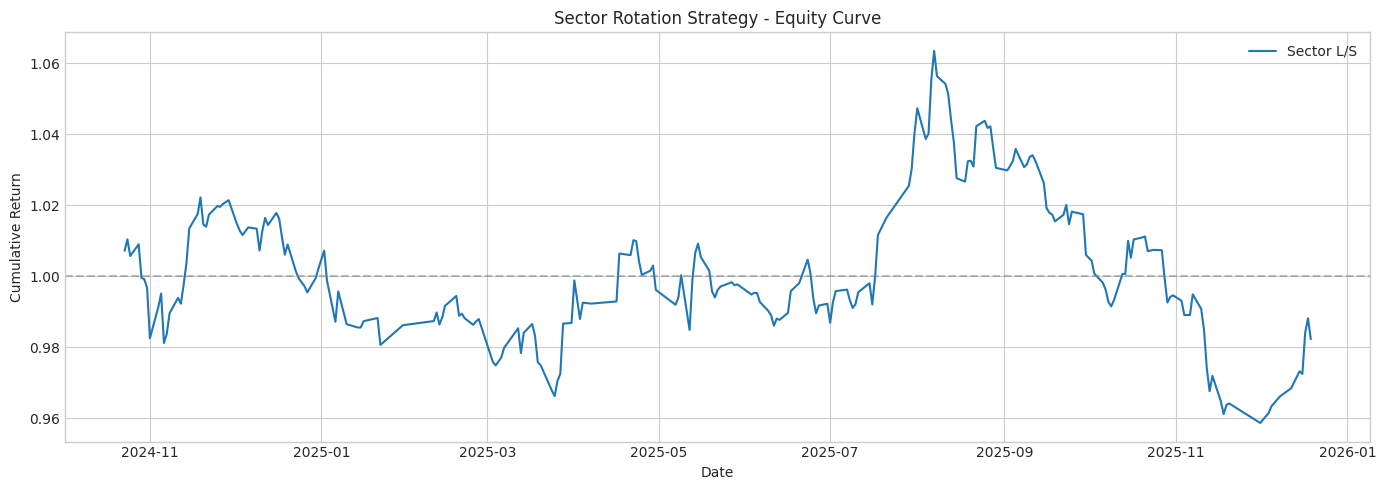

In [43]:
# Equity curve
if len(strat_df) > 0:
    strat_df['cumulative'] = (1 + strat_df['ls_return']).cumprod()
    
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(strat_df['trade_date'], strat_df['cumulative'], label='Sector L/S')
    ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title('Sector Rotation Strategy - Equity Curve')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [44]:
# Cost-adjusted
ETF_SPREAD = 0.0003  # 3 bps round-trip for liquid ETFs
ETF_COMMISSION = 0.0001  # 1 bp
DAILY_COST = ETF_SPREAD + ETF_COMMISSION * 2  # Entry + exit

print("\n" + "=" * 60)
print("COST-ADJUSTED RETURNS")
print("=" * 60)
print(f"Daily trading costs: {DAILY_COST*100:.2f}%")
print()

strat_df['ls_net'] = strat_df['ls_return'] - DAILY_COST
compute_metrics(strat_df['ls_net'], 'L/S After Costs')


COST-ADJUSTED RETURNS
Daily trading costs: 0.05%

L/S After Costs:
  Annual Return: -14.1%
  Annual Vol:    8.4%
  Sharpe:        -1.68
  Win Rate:      45.8%


-1.6767539733041648

In [45]:
# Sector selection frequency
print("\n" + "=" * 60)
print("SECTOR SELECTION FREQUENCY")
print("=" * 60)

print("\nMost often LONG (top score):")
print(strat_df['top_sector'].value_counts().head(5))

print("\nMost often SHORT (bottom score):")
print(strat_df['bottom_sector'].value_counts().head(5))


SECTOR SELECTION FREQUENCY

Most often LONG (top score):
top_sector
XLRE    121
XLU      76
XLP      17
XLE       8
XLF       8
Name: count, dtype: int64

Most often SHORT (bottom score):
bottom_sector
XLV    206
XLC     11
XLB      9
XLK      8
XLE      4
Name: count, dtype: int64


In [46]:
# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

ls_arr = strat_df['ls_return'].values
ls_net_arr = strat_df['ls_net'].values

print(f"\nTest period: {strat_df['date'].min().date()} to {strat_df['date'].max().date()}")
print(f"Trading days: {len(strat_df)}")
print(f"")
print(f"Gross L/S: {np.mean(ls_arr)*252*100:.1f}% ann (Sharpe {np.mean(ls_arr)/np.std(ls_arr)*np.sqrt(252):.2f})")
print(f"Net L/S:   {np.mean(ls_net_arr)*252*100:.1f}% ann (Sharpe {np.mean(ls_net_arr)/np.std(ls_net_arr)*np.sqrt(252):.2f})")
print(f"")
if np.mean(ls_net_arr) > 0:
    print("VERDICT: Potentially viable - warrants further investigation")
else:
    print("VERDICT: Not viable - sector aggregation doesn't recover signal")


SUMMARY

Test period: 2024-10-22 to 2025-12-18
Trading days: 238

Gross L/S: -1.5% ann (Sharpe -0.18)
Net L/S:   -14.1% ann (Sharpe -1.68)

VERDICT: Not viable - sector aggregation doesn't recover signal
